# Data Summary
The data set being analyzed is a simulated Human Resources data that contains numerical and categorical attributes. 

Employee attributes in data set include: satisfaction level, previous evaluation score, number of projects, average monthly hours spent at the office, tenure at the company, whether or not a work accident was observed, whether or not the employee left, whether or not the employee received a promotion, pay grade, and the position the employee held or is currently holding. 

The data can be downloaded from kaggle at: https://www.kaggle.com/ludobenistant/hr-analytics


# Research Questions & Hypotheses 

The focus of this analysis is three-fold. We want to better understand 1) the current attrition rate of highly valued employees (those that received >.7 on their last evaluation) and what factors play into employees leaving, 2) what factors contribute to employee satisfaction and 3) when employees leave the company. 

By answering these questions, we hope to provide a framework for human resource managers to work with so that they can confidently form a strategy to both improve employee retention and satisfaction.


### RQ1: What are key factors that are playing into current attrition rates?

H1: Highly evaluated employees (>.7) who have a low to moderate (<6) number of projects tend to stay at the company.

H2: Highly evaluated employees (>.7) who have a low to moderate average monthly hours (<220) tend to stay at the company.

H3: Highly evaluated (>.7) employees who receive promotions tend to stay at the company.

H4: Highly evaluated (>.7) employees who receive higher pay tend to stay at the company.

### RQ2: What are key factors that are playing into current satisfaction ratings?

H5: Highly evaluated employees (>.7) who have a low to moderate number of projects (<6) tend to be more satisfied. 

H6: Highly evaluated employees (>.7) who have a low to moderate average monthly hours (<220) tend to be more satisfied. 

H7: Highly evaluated (>.7) employees who receive promotions tend to be more satisfied. 

H8: Highly evaluated (>.7) employees who receive high salaries tend to be more satisfied.  

### RQ3: When are employees leaving? 

H9: Employees who are highly evaluated, have low to moderate project loads, work low to moderate average monthly hours and are highly satisfied (>.7) will tend to stay at the company longer.






## Preliminary Assessment of Data
The preliminary assessment process helps identify what attributes merit further investigation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
from scipy.stats import ttest_ind
import scipy.stats
%matplotlib inline

In [2]:
#read in .csv
df = pd.read_csv('HR_comma_sep.csv')

#preview first 5 rows of data frame
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [3]:
#Column assignment coventions taken from Randy Lao on Kaggle

df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

The first step of the analysis involves slicing the dataframe to focus on the population we want to investigate: highly evaluated employees

In [4]:
#Subset data set to focus on population of employees with >.7 evaluatinos

good_employees = df[df['evaluation'] > .7]

In [5]:
#Evaluate size of data set

good_employees.shape

(7802, 10)

In [6]:
turnover = good_employees.turnover.value_counts()/7802

In [7]:
#Evaluate how many people are leaving the company; it will be important for managers to understand current attrition rate

turnover_summary = good_employees.groupby('turnover')
turnover_summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.678909,0.849400,3.820369,202.818166,3.378919,0.175563,0.027114
1,0.463351,0.894982,5.299842,257.044187,4.571278,0.047344,0.002104


#### Identifying attributes for analysis
The correlation heat map is a useful tool to give us direction on which attributes to focus on our for this analysis. 
Some attributes that we'll focus on include: project count and average number of hours spent at the company in a given month. 

There are also some additional non-numeric features that will be assessed in the analysis including salary level (low, medium, high) and promotions.

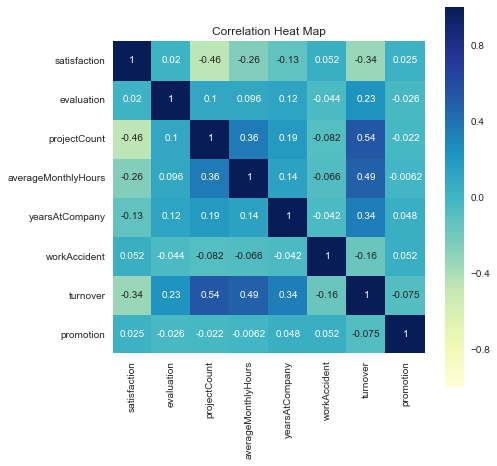

In [8]:
correlation = good_employees.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap="YlGnBu")
plt.title('Correlation Heat Map')


#### Distribution of satisfaction
For RQ2, we'll be focusing on how satisfaction changes across our population. Before we can explore, let's first get a sense of how satisfaction is distributed. 

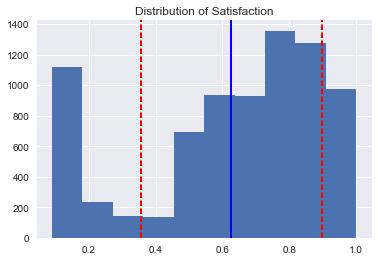

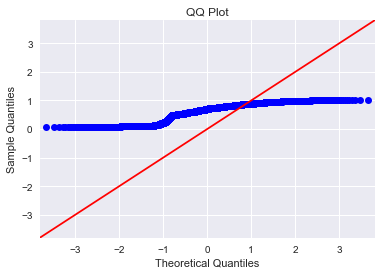

In [9]:
satisfaction = good_employees['satisfaction']

plt.title('Distribution of Satisfaction')
#Plot distribution of attribute
plt.hist(satisfaction)

#Create solid line at mean
plt.axvline(satisfaction.mean(),color='b',linestyle='solid',linewidth=2)

#Create dotted line 1 st dev below mean
plt.axvline(satisfaction.mean()-satisfaction.std(),color='r',linestyle='dashed',linewidth=2)

#Create dotted line 1 st dev above mean
plt.axvline(satisfaction.mean()+satisfaction.std(),color='r',linestyle='dashed',linewidth=2)

#Show plot
plt.show()

# Create QQ Plot
sm.qqplot(satisfaction,line='45')
plt.title('QQ Plot')
pylab.show()

Satisfaction for highly evaluated employees appears to have non-normal distribution and a left skew. We will have to use a statistical test that works well with non-normal distributions when evaluating this attribute. 

#### Distribution of Average Monthly Hours

We suspect that average monthly hours might play a role both in attrition rates and overall employee satisfaction. Again, before we can investigate further, we need to better understand how the data is distributed.

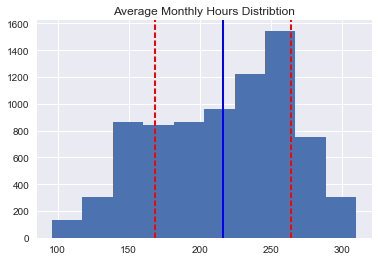

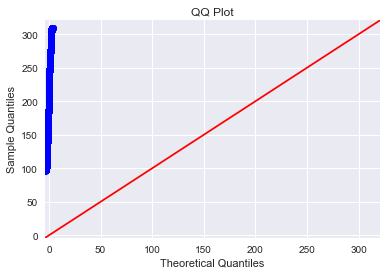

In [10]:
averageMonthlyHours = good_employees['averageMonthlyHours']

plt.title('Average Monthly Hours Distribtion')

#Plot distribution of attribute
plt.hist(averageMonthlyHours)

#Create solid line at mean
plt.axvline(averageMonthlyHours.mean(),color='b',linestyle='solid',linewidth=2)

#Create dotted line 1 st dev below mean
plt.axvline(averageMonthlyHours.mean()-averageMonthlyHours.std(),color='r',linestyle='dashed',linewidth=2)

#Create dotted line 1 st dev above mean
plt.axvline(averageMonthlyHours.mean()+averageMonthlyHours.std(),color='r',linestyle='dashed',linewidth=2)

#Show plot
plt.show()

#Create QQ Plot
sm.qqplot(averageMonthlyHours,line='45')
plt.title('QQ Plot')
pylab.show()

Average monthly hours for highly evaluated employees has a non-normal distribution with a slight left skew. We will have to use a statistical test that works well with non-normal distributions when evaluating this attribute. 

#### Distribution of projectCount

We suspect that average monthly hours might play a role both in attrition rates and overall employee satisfaction, this will be the last distribution to evaluate.

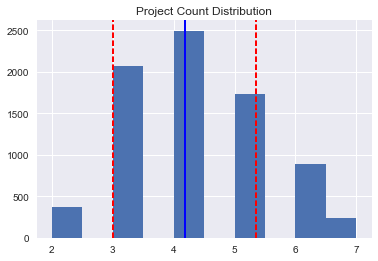

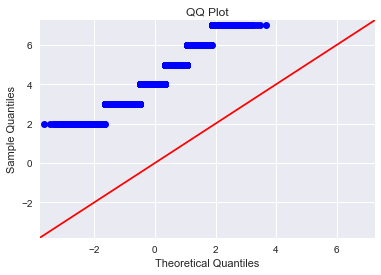

In [11]:
projectCount = good_employees['projectCount']

plt.title('Project Count Distribution')

#Plot distribution of attribute
plt.hist(projectCount)

#Create solid line at mean
plt.axvline(projectCount.mean(),color='b',linestyle='solid',linewidth=2)

#Create dotted line 1 st dev below mean
plt.axvline(projectCount.mean()-projectCount.std(),color='r',linestyle='dashed',linewidth=2)

#Create dotted line 1 st dev above mean
plt.axvline(projectCount.mean()+projectCount.std(),color='r',linestyle='dashed',linewidth=2)

#Show plot
plt.show()

sm.qqplot(projectCount,line='45')
plt.title('QQ Plot')
pylab.show()

Project count for highly evaluated employees has a non-normal distribution with a slight right skew. We will have to use a statistical test that works well with non-normal distributions when evaluating this attribute. 

# RQ1: What are key factors that are playing into current attrition rates? 

#### Benchmarking current attrition rate

Before we conduct a deeper investigation to what factors play into attrition, it is useful to look at what the current attrition rate is. This will serve as a valuable initial benchmark for managers to reference back to after measures to improve retention are implemented. 

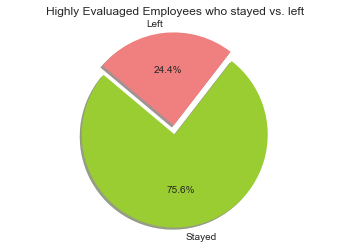

In [44]:
plt.title("Highly Evaluaged Employees who stayed vs. left")
labels = 'Stayed', 'Left'
sizes = [5901,1901]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()


In [13]:
#Look at distribution of employees who left/stayed for good employees

good_employees.turnover.value_counts()

0    5901
1    1901
Name: turnover, dtype: int64

### H1: Highly evaluated employees (>.7) who have a low to moderate (<6) number of projects tend to stay at the company. 

The following histogram will be used to help us initially evaluate whether there's a clear difference in the distribution of project loads between highly evaluated employees who left versus highly evaluated employees who stayed. We expect to find that employees with high project loads (>=6) will tend to leave versus employees with low to moderate project loads (<6), who will tend to stay. The idea is that those who have an excessive amount of projects are overworked and therefore do not stay at the company nearly as long. We'll also conduct a Mann-Whitney U test to help validate whether these differences are meaningful.


In [14]:
good_employees_left = good_employees[good_employees['turnover'] == 1]
good_employees_stayed = good_employees[good_employees['turnover'] == 0]

projectCount & turnover - Pearson R =  (0.54097413566527808, 0.0)  and projectCount between good employees who left/stayed Mann-Whitney =  MannwhitneyuResult(statistic=1839715.0, pvalue=0.0) 


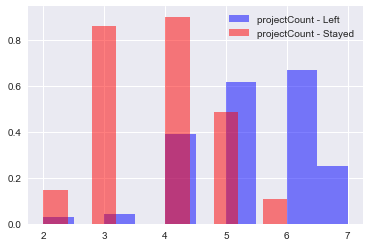

In [15]:
plt.hist(good_employees_left['projectCount'],alpha=.5,color='blue',label='projectCount - Left',normed=True)
plt.hist(good_employees_stayed['projectCount'],alpha=.5,color='red',label='projectCount - Stayed',normed=True)
plt.legend()

pear_r = scipy.stats.pearsonr(good_employees['projectCount'],good_employees['turnover'])
mann = scipy.stats.mannwhitneyu(good_employees_stayed['projectCount'],good_employees_left['projectCount'])

print("projectCount & turnover - Pearson R = ",pear_r," and projectCount between good employees who left/stayed Mann-Whitney = ",mann,"")




There's a moderate positive correlation of .54 between project count and turnover, which supports our expectation that employees who are strained with higher project loads tend to leave the company versus employees who have low to moderate work loads. To understand the significance of the relationship between project load and turnover, we'll look at how turnover changes across employees with high project loads versus employees with low to moderate project loads. We'll also be conducting a Mann-Whitney U test to further help assess whether these differences in turnover are meaningful or not. 

In [16]:
high_projects = df.query('evaluation>.7 & projectCount>=6')
low_projects = df.query('evaluation>.7 & projectCount<6')

In [17]:
print(high_projects.turnover.value_counts())
print(low_projects.turnover.value_counts())

1    874
0    252
Name: turnover, dtype: int64
0    5649
1    1027
Name: turnover, dtype: int64


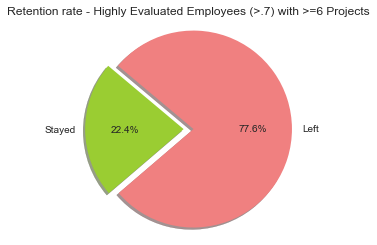

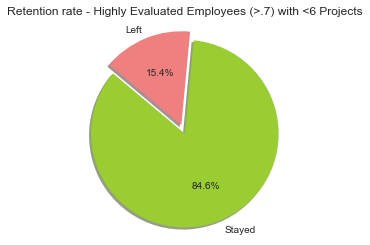

In [49]:
plt.title("Retention rate - Highly Evaluated Employees (>.7) with >=6 Projects")
labels = 'Stayed', 'Left'
sizes = [252,874]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()

plt.title("Retention rate - Highly Evaluated Employees (>.7) with <6 Projects")
labels = 'Stayed', 'Left'
sizes = [5649,1027]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()

In [19]:
print(scipy.stats.mannwhitneyu(high_projects['turnover'],low_projects['turnover']))


MannwhitneyuResult(statistic=1419377.0, pvalue=0.0)


The turnover rate jumps by 62.2% between the employees with low to moderate project loads to employees with high project loads. This suggests that making sure employees are not taking on too many projects and taking steps to ensure that their managers are keeping their project loads low to moderate could dramatically improve retention. 

## H2: Highly evaluated employees (>.7) who have a low to moderate average monthly hours (<220) tend to stay at the company.

The following histogram will be used to help us initially evaluate whether there's a clear difference in the distribution of average monthly hours between highly evaluated employees who left versus highly evaluated employees who stayed. We  expect that employees who are on the higher end of the average monthly hour spectrums will tend to leave from being overworked, whereas employees who work more moderate hours tend to stay. We'll also conduct a Mann-Whitney U test to help validate whether these differences are meaningful.

averageMonthlyHours & turnover - Pearson R =  (0.4870738251442957, 0.0)  and averageMonthlyHours between good employees who left/stayed Mann-Whitney =  MannwhitneyuResult(statistic=1877695.5, pvalue=0.0) 


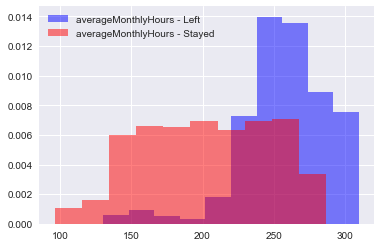

In [20]:
plt.hist(good_employees_left['averageMonthlyHours'],alpha=.5,color='blue',label='averageMonthlyHours - Left',normed=True)
plt.hist(good_employees_stayed['averageMonthlyHours'],alpha=.5,color='red',label='averageMonthlyHours - Stayed',normed=True)
plt.legend()

pear_r = scipy.stats.pearsonr(good_employees['averageMonthlyHours'],good_employees['turnover'])
mann = scipy.stats.mannwhitneyu(good_employees_stayed['averageMonthlyHours'],good_employees_left['averageMonthlyHours'])

print("averageMonthlyHours & turnover - Pearson R = ",pear_r," and averageMonthlyHours between good employees who left/stayed Mann-Whitney = ",mann,"")



There's a moderate positive correlation of .48 between average monthly hours and turnover, which supports our expectation that employees who are overworked tend to leave the company. To understand the significance of the relationship between average monthly hours and turnover, we'll look at how turnover changes across emoloyees with high average monthly hours (>=220) versus low monthly hours (<220). We'll also be conducting a Mann-Whitney U test to further help assess whether these differences in turnover are meaningful or not. 

In [21]:
high_hours = df.query('evaluation>.7 & averageMonthlyHours>=220')
low_moderate_hours = df.query('evaluation>.7 & projectCount<220')

In [22]:
print(high_hours.turnover.value_counts())
print(low_moderate_hours.turnover.value_counts())

0    2356
1    1754
Name: turnover, dtype: int64
0    5901
1    1901
Name: turnover, dtype: int64


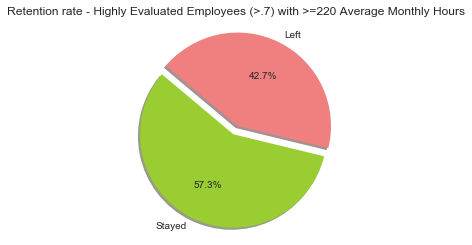

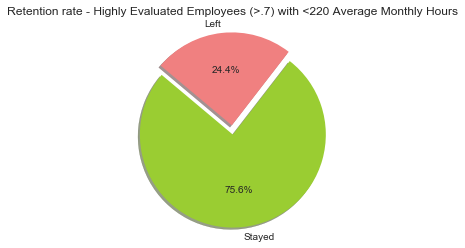

In [50]:
plt.title("Retention rate - Highly Evaluated Employees (>.7) with >=220 Average Monthly Hours")
labels = 'Stayed', 'Left'
sizes = [2356,1754]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()

plt.title("Retention rate - Highly Evaluated Employees (>.7) with <220 Average Monthly Hours")
labels = 'Stayed', 'Left'
sizes = [5901,1901]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()

In [24]:
print(scipy.stats.mannwhitneyu(high_hours['turnover'],low_moderate_hours['turnover']))


MannwhitneyuResult(statistic=13097311.0, pvalue=1.3933209051774937e-94)


The turnover rate jumps by 18.3% between the employees with low-moderate average monthly hours to employees with high average monthly hours. This suggests that making sure employees are not working too many hours could improve retention. It's interesting to see that this increase in retention isn't similar to the jump in retention between high and low project loads. While it's possible that some employees who are working high average monthly hours are being overworked and therefore choose to leave, it would be interesting to see if there are some instances where employees don't necessarily mind working high average monthly hours, so long as their project docket is focused rather than spread out.

## H3: Highly evaluated (>.7) employees who receive promotions tend to stay at the company.

In [25]:
good_employees_promo = good_employees[good_employees['promotion'] == 1]
good_employees_no_promo = good_employees[good_employees['promotion'] == 0]

print(good_employees_promo.turnover.value_counts())
print(good_employees_no_promo.turnover.value_counts())


0    160
1      4
Name: turnover, dtype: int64
0    5741
1    1897
Name: turnover, dtype: int64


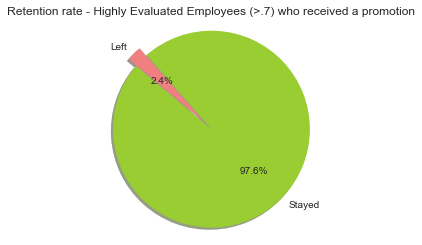

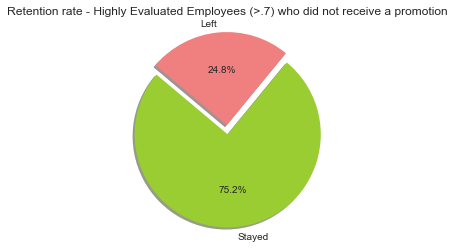

In [51]:
plt.title("Retention rate - Highly Evaluated Employees (>.7) who received a promotion")
labels = 'Stayed', 'Left'
sizes = [160,4]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()

plt.title("Retention rate - Highly Evaluated Employees (>.7) who did not receive a promotion")
labels = 'Stayed', 'Left'
sizes = [5741,1897]
colors = ['yellowgreen','lightcoral']
explode = [0.1,0]

plt.pie(sizes,explode=explode,labels=labels,colors=colors,
        autopct='%1.1f%%',shadow=True,startangle=140)

plt.axis('equal')
plt.show()


The turnover rate jumps by 22.4% between the employees who received a promotion to employees did not receive a promotion. This suggests that offering promotions is a reasonable incentive to help increase employee retention. 

## H4: Highly evaluated (>.7) employees who receive higher pay tend to stay at the company.

In [27]:
high_sal = good_employees[good_employees['salary'] == 'high']
med_sal = good_employees[good_employees['salary'] == 'medium']
low_sal = good_employees[good_employees['salary'] == 'low']

print(high_sal.turnover.value_counts())
print(med_sal.turnover.value_counts())
print(low_sal.turnover.value_counts())

0    586
1     28
Name: turnover, dtype: int64
0    2645
1     727
Name: turnover, dtype: int64
0    2670
1    1146
Name: turnover, dtype: int64


In [28]:
print(scipy.stats.mannwhitneyu(high_sal['turnover'],low_sal['turnover']))


MannwhitneyuResult(statistic=873114.0, pvalue=1.6982308409071546e-40)


Attrition for high salary is  0.04560260586319218 
Attrition for med salary is  0.21559905100830368 
Attrition for low salary is  0.300314465408805 


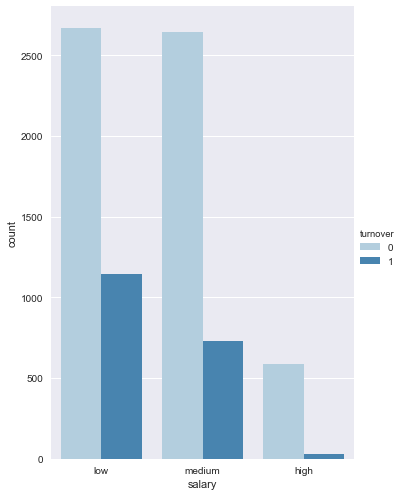

In [29]:
g = sns.factorplot(x="salary",hue="turnover",data=good_employees,kind="count",order=['low','medium','high'],size=7,aspect=.7,palette="Blues")
print("Attrition for high salary is ",28/614,"")
print("Attrition for med salary is ",727/3372,"")
print("Attrition for low salary is ",1146/3816,"")


The turnover rate is reduced by 25.5% between the employees who receive low salaries to employees receive high salaries. This suggests that, in addition to offering promotions, salary increases can also help further increase employee retention. Moreover, the increase in retention is far more significant from medium to high salaried employees (17%) compared to the difference between low to medium salaried employees (9%). The higher the salary, the greater the impact on retention. 

# RQ2: What are key factors that are playing into current satisfaction ratings? 

The following histogram will help us initially evaluate whether there's a clear difference in the distribution of satisfaction between highly evaluated employees who left versus highly evaluated employees who stayed. We  expect that employees who tend to stay at the company tend to be more satisfied than those that leave. We'll also conduct a Mann-Whitney U test to help validate whether these differences are meaningful or not.

satisfaction & turnover - Pearson R =  (-0.34145072868698284, 2.8696382574929443e-212)  and satisfaction between good employees who left/stayed Mann-Whitney =  MannwhitneyuResult(statistic=3877753.0, pvalue=1.1063388530032577e-91) 


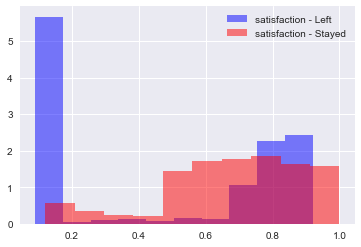

In [30]:
plt.hist(good_employees_left['satisfaction'],alpha=.5,color='blue',label='satisfaction - Left',normed=True)
plt.hist(good_employees_stayed['satisfaction'],alpha=.5,color='red',label='satisfaction - Stayed',normed=True)
plt.legend()

pear_r = scipy.stats.pearsonr(good_employees['satisfaction'],good_employees['turnover'])
mann = scipy.stats.mannwhitneyu(good_employees_stayed['satisfaction'],good_employees_left['satisfaction'])

print("satisfaction & turnover - Pearson R = ",pear_r," and satisfaction between good employees who left/stayed Mann-Whitney = ",mann,"")


There's a low to moderate negative correlation of -.34 between satisfaction and turnover, which supports our expectation that employees who stay tend to be more satisfied compared to those that left. To understand the significance of the relationship between between satisfaction and project load, we'll look at how satisfaction changes across employees with high project loads versus employees with low to moderate project loads. We'll also conduct a Mann-Whitney U test to further help assess whether these differences in satisfaction are meaningful or not. 

## H5: Highly evaluated employees who have a low to moderate number of projects (<6) tend to be more satisfied. 

0.19203374777975266
0.6996464949071273


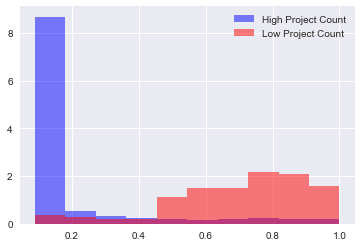

In [31]:
plt.hist(high_projects['satisfaction'],alpha=.5,color='blue',label='High Project Count',normed=True)
plt.hist(low_projects['satisfaction'],alpha=.5,color='red',label='Low Project Count',normed=True)
plt.legend()
print(high_projects['satisfaction'].mean())
print(low_projects['satisfaction'].mean())

In [32]:
print(scipy.stats.mannwhitneyu(high_projects['satisfaction'],low_projects['satisfaction']))


MannwhitneyuResult(statistic=493074.5, pvalue=0.0)


Employees with low to medium projects loads report about a 50% higher satisfaction rating. This suggests that making sure employees are not taking on too any projects and taking steps to ensure that their managers are keeping their projects low to moderate could dramatically improve employee satisfaction levels. 

## H6: Highly evaluated employees (>.7) who have a low to moderate average monthly hours (<220) tend to be more satisfied. 


To understand the significance of the relationship between between satisfaction and average monthly hours, we'll look at the distribution of satisfaction levels across employees with high average monthly hours (>=220) versus employees with low to moderate average monthly hours (<220). We'll also conduct a Mann-Whitney U test to further help assess whether these differences in satisfaction are meaningful or not. 

0.5830024330900235
0.6263868238913091


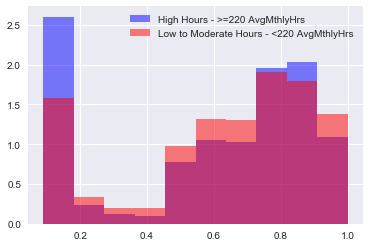

In [33]:
plt.hist(high_hours['satisfaction'],alpha=.5,color='blue',label='High Hours - >=220 AvgMthlyHrs',normed=True)
plt.hist(low_moderate_hours['satisfaction'],alpha=.5,color='red',label='Low to Moderate Hours - <220 AvgMthlyHrs',normed=True)
plt.legend()
print(high_hours['satisfaction'].mean())
print(low_moderate_hours['satisfaction'].mean())

In [34]:
print(scipy.stats.mannwhitneyu(high_hours['satisfaction'],low_moderate_hours['satisfaction']))


MannwhitneyuResult(statistic=15045214.0, pvalue=1.5243783900625216e-08)


Employees with low to medium average monthly hours report 4% higher satisfaction rating. This suggests that making sure employees are not working too many hours could improve satisfaction levels, albeit margially.

## H7: Highly evaluated (>.7) employees who receive promotions tend to be more satisfied. 

To understand the significance of the relationship between between satisfaction and promotions, we'll look at the distribution of satisfaction levels across employees who received a promotion versus employees who did not receive a promotion. We'll also conduct a Mann-Whitney U test to further help assess whether these differences in satisfaction are meaningful or not. 

0.6729268292682924
0.6253875360041891


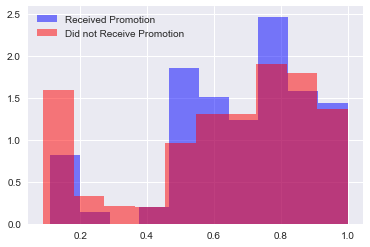

In [35]:
plt.hist(good_employees_promo['satisfaction'],alpha=.5,color='blue',label='Received Promotion',normed=True)
plt.hist(good_employees_no_promo['satisfaction'],alpha=.5,color='red',label='Did not Receive Promotion',normed=True)
plt.legend()
print(good_employees_promo['satisfaction'].mean())
print(good_employees_no_promo['satisfaction'].mean())

In [36]:
print(scipy.stats.mannwhitneyu(good_employees_promo['satisfaction'],good_employees_no_promo['satisfaction']))


MannwhitneyuResult(statistic=585980.5, pvalue=0.078745271399617067)


Employees with low to medium average monthly hours report a 5% higher satisfaction rating. This suggests that offering a promotion can increase satisfaction, albeit marginally. 

## H8: Highly evaluated (>.7) employees who receive high salaries tend to be more satisfied. 

To understand the significance of the relationship between between satisfaction and salary level, we'll look at the distribution of satisfaction levels across employees with low, medium and high salaries. We'll also conduct a Mann-Whitney U test to further help assess whether these differences in satisfaction are meaningful or not. 

0.6149318658280919
0.6364294187425861
0.6424267100977196


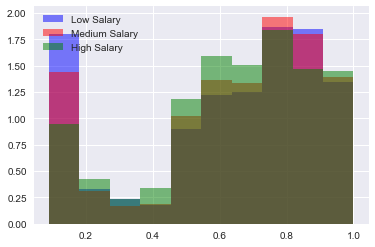

In [37]:
plt.hist(low_sal['satisfaction'],alpha=.5,color='blue',label='Low Salary',normed=True)
plt.hist(med_sal['satisfaction'],alpha=.5,color='red',label='Medium Salary',normed=True)
plt.hist(high_sal['satisfaction'],alpha=.5,color='green',label='High Salary',normed=True)
plt.legend()

print(low_sal['satisfaction'].mean())
print(med_sal['satisfaction'].mean())
print(high_sal['satisfaction'].mean())

In [38]:
print(scipy.stats.mannwhitneyu(high_sal['satisfaction'],low_sal['satisfaction']))


MannwhitneyuResult(statistic=1145954.5, pvalue=0.19240327406570273)


The p value from our Mann-Whitney U test is not less than .01, therefore we accept the null hypothesis. This suggests that using promotions as means to improve employee satisfaction is ultimately an ineffective approach. 

# RQ3: When are employees leaving? 

Now that we have a better understanding of attributes increase retention and satisfaction, let's try to better understand when attrition occurs. Knowing when attrition occurs can help managers better understand when an employee or employee population may be at risk for leaving so that they can intervene accordingly. 

To form a baseline, let's first across the entire human resources data set and look at when attrition tends to spike.

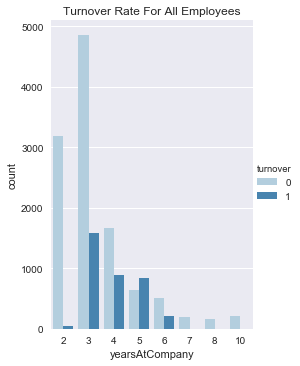

In [39]:
satisfied_good_employees = good_employees[good_employees['satisfaction'] > .7]

sns.factorplot(x="yearsAtCompany",hue="turnover",data=df,kind="count",size=5,aspect=.7,palette="Blues")
plt.title("Turnover Rate For All Employees")

We see that at year 3, a lot of employees tend to leave the company. Now let's look at our focus population: highly evaluated employees, and see whether attrition changes or not.

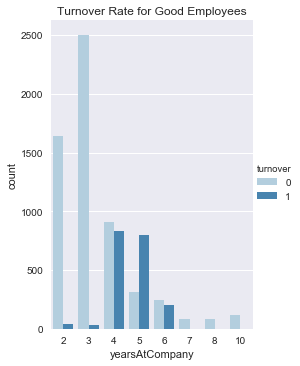

In [40]:
sns.factorplot(x="yearsAtCompany",hue="turnover",data=good_employees,kind="count",size=5,aspect=.7,palette="Blues")
plt.title("Turnover Rate for Good Employees")




We see that employees who are highly evaluted, the spike in attrition is delayed by a year. Let's consider one of our research focuses, satisfaction, and see whether or not attrition changes for highly valued, highly satisfied employees. We would expect any sort of attrition spike to occur later since we know that employees who are satisfied tend to stay the company.

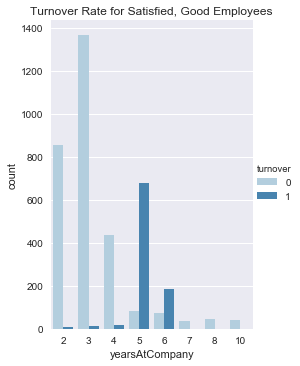

In [41]:
sns.factorplot(x="yearsAtCompany",hue="turnover",data=satisfied_good_employees,kind="count",size=5,aspect=.7,palette="Blues")
plt.title("Turnover Rate for Satisfied, Good Employees")

We see that for employees who are highly evaluated and highly satisfied, the attrition spikes moves again by yet another year. As a final point of investiation, let's look look at what attrition looks like for a 'model employee' population, where all employees are highly evaluated, have low to moderate project loads, are highly satisfied and work low to moderate average monthly hours. We expect attrition to be minimal given the findings of our above analysis.

## H9: Employees who are highly evaluated, have low to moderate project loads, work low to moderate average monthly hours and are highly satisfied (>.7) will tend to stay at the company loger.

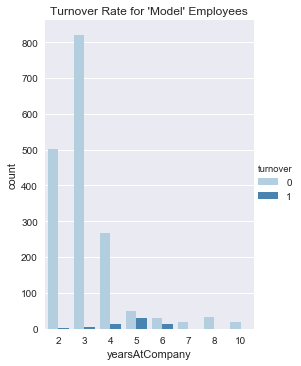

In [52]:
model_employee = df.query('evaluation>.7 & projectCount<6 & satisfaction>.7 & averageMonthlyHours<220')

sns.factorplot(x="yearsAtCompany",hue="turnover",data=model_employee,kind="count",size=5,aspect=.7,palette="Blues")
plt.title("Turnover Rate for 'Model' Employees")

In [43]:
print(scipy.stats.mannwhitneyu(model_employee['turnover'],df['turnover']))


MannwhitneyuResult(statistic=10789809.5, pvalue=1.5277801773514387e-86)


We see that in our 'model employee' population, there's no discernable attrition spike -- this suggests that creating and enforcing to focus on optimizing the attributes investigated in our research could dramatically reduce retention across the board.

# Conclusion

The null hypothesis is rejected for all hypotheses except for H8. 

The greatest disparity in turnover rate (62.2%) was observed between highly evaluated employees with low to moderate project loads vs. high project loads. Coincidentally, the greatest disparity in satisfaction (50%) was also observed between the two aformentioned subpopulations. 

Turnover rate and satisfaction levels were improved (18.3% and 4% respectively) for employees who worked a low to moderate amount of average monthly hours vs high average monthly hours. 

Workplace incentives such as promotions and higher salaries were found to be effective in reducing turnover (22.4% and 25.5% respectively) but were found to be an ineffective means at increasing employee satisfaction. 

Lastly, our assessment of when attrition tends to occur not only helps identify employee populations at risk of leaving, but also demonstrates how attrition might be dramatically lowered by optimizing the attributes investigated in the analysis. 


# Further Research

The only features evaluated in this research were average monthly hours, project count, promotions, satisfaction and salary. And while the findings in this analysis might help give indication to when employees might be at risk of leaving and what might be done to prevent them from leaving, we're ultimately only getting part of the picture. More sophisticated approaches should factor in all of the attributes and understand how they effect one another. 

One approach might be to build a machine learning algorithm that factors in all of the attributes in the data set to more effectively forecast attrition. It would also be interesting to build a decision tree that also factors in all of the data sets attributes to see how critical each attribute is to retention. 